# 데이터 전처리 이해와 실무

## `데이터 변환: 특징 생성`

### 특징 생성(강의 교안)
1. 범주 인코딩 기반 생성
2. 결합 및 분해 기반 생성
3. 차원 축소 기반 생성(알고리즘 적용)

### 실습 내용 요약
- 예제 데이터 활용 범주형 변수 인코딩
- 결합 및 분해 기반 신규 특징 생성을 비롯한 주성분 분석
- 군집분석 기반 특징 실습까지 실습

### 실습 시 활용 패키지
- pandas
- numpy
- scikit-learn
- matplotlib
- seaborn

## 1. 범주 인코딩 기반 생성
- 숫자로 표현되지 않은 데이터를 수치형으로 표현하고 모델링에 적용하기 위한 과정

In [1]:
import numpy as np
import pandas as pd

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Parameters for each city
city_data = {
    '대전': 107,
    '서울': 77,
    '광주': 69,
    '부산': 35,
    '대구': 12
}

# Total number of rows
total_rows = sum(city_data.values())

# Generate random data
np.random.seed(42)  # For reproducibility

# Lists to store data
dates = []
purchase_YNs = []
genders = []
cities = []

# Generate data for each city
for city, count in city_data.items():
    for _ in range(count):
        # Random date between 2020-01-01 and 2020-12-31
        random_date = datetime(2020, 1, 1) + timedelta(days=np.random.randint(0, 365),
                                                       seconds=np.random.randint(0, 86400))
        dates.append(random_date.strftime('%Y-%m-%d %H:%M'))
        
        # Random purchase_YN (1 or 0)
        purchase_YNs.append(np.random.randint(0, 2))
        
        # Random gender ('M' or 'F')
        genders.append(np.random.choice(['M', 'F']))
        
        # Append city
        cities.append(city)

# Create DataFrame
df = pd.DataFrame({
    'date': dates,
    'purchase_YN': purchase_YNs,
    'gender': genders,
    'city': cities
})

# Display DataFrame and check counts
print(df.head())
print(df['city'].value_counts())
print(f"Total number of rows: {len(df)}")

# 데이터프레임을 CSV 파일로 저장
df.to_csv('./data/encoding_sample_data.csv', index=False)

               date  purchase_YN gender city
0  2020-04-12 04:23            0      M   대전
1  2020-04-16 21:20            0      F   대전
2  2020-08-02 10:19            0      F   대전
3  2020-04-09 16:44            1      M   대전
4  2020-05-29 18:00            1      F   대전
city
대전    107
서울     77
광주     69
부산     35
대구     12
Name: count, dtype: int64
Total number of rows: 300


In [3]:
# 실습 데이터 loading : 교육 실습을 위한 생성 데이터
# 데이터 로딩 및 개요 확인
data = pd.read_csv("./data/encoding_sample_data.csv")
data.head()

,date,purchase_YN,gender,city
0,2020-04-12 04:23,0,M,대전
1,2020-04-16 21:20,0,F,대전
2,2020-08-02 10:19,0,F,대전
3,2020-04-09 16:44,1,M,대전
4,2020-05-29 18:00,1,F,대전


In [4]:
# city의 범주와, 범주별 개수를 확인해보자
data['city'].value_counts() # 5개 범주

city
대전    107
서울     77
광주     69
부산     35
대구     12
Name: count, dtype: int64

In [5]:
# city라는 범주형 변수에 대해 --> one-hot encoding 진행
# Pandas의 get_dummies 함수 활용하여 쉽게 구현 가능
encoding_data = data.copy()
encoding_data = pd.get_dummies(encoding_data, columns = ['city']) # .get_dummies(데이터명, 원핫인코딩 수행할 컬럼명)
encoding_data.head()

# 실행결과: 5개 범주를 지닌 기존 city 컬럼 --> 각각 city_도시명으로 5개 컬럼이 생성(원래 city컬럼은 사라짐)
# get_dummies 함수를 통해 --> 원본 데이터의 city 변수 대신 --> 각 범주별 변수가 생성됨(1개 변수 -> 5개 변수)

,date,purchase_YN,gender,city_광주,city_대구,city_대전,city_부산,city_서울
0,2020-04-12 04:23,0,M,False,False,True,False,False
1,2020-04-16 21:20,0,F,False,False,True,False,False
2,2020-08-02 10:19,0,F,False,False,True,False,False
3,2020-04-09 16:44,1,M,False,False,True,False,False
4,2020-05-29 18:00,1,F,False,False,True,False,False


- One-hot Encoding은 각 범주의 요소마다 별도 컬럼으로 생성하여 True/False를 표현
- 기계 학습의 많은 알고리즘은 수치형 데이터를 입력값으로 받아야 함
- 따라서, 범주형 변수의 One-hot Encoding 기법을 활용하여 기계학습 적용의 제약점을 해소 가능

## 2. 결합 및 분해 기반 생성
- 기존 원본 데이터에 나타나지 않는 새로운 의미의 변수를 생성하고자 하며,
- 다양한 파생 변수를 생성해서 데이터 특성을 파악하거나 모델링에 활용하기 위해서 활용되는 방안
- 특징을 생성할 때 도메인 지식, 혹은 일반적 관념 기준으로 할 수 있음

In [6]:
# 구매와 관련된 시간적 요소를 파악하고 싶다! (분석목적: 시간대별 파악)
# 어느 시간대 혹은 요일별로 구매 결정이 높아지는지 확인하고자 할 때

creation_data = data.copy()
creation_data.info() # 시간적 요소의 파악이 목적이니 'date' 칼럼 확인 --> object 형태여서 형식 바꾸어야 할 필요!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         300 non-null    object
 1   purchase_YN  300 non-null    int64 
 2   gender       300 non-null    object
 3   city         300 non-null    object
dtypes: int64(1), object(3)
memory usage: 9.5+ KB


In [7]:
# 기존 범주형 변수인 date 컬럼을 datetime 형식으로 변환
creation_data['date'] = pd.to_datetime(creation_data['date'])
creation_data.head() # 형상은 크게 달라지진 않음

,date,purchase_YN,gender,city
0,2020-04-12 04:23:00,0,M,대전
1,2020-04-16 21:20:00,0,F,대전
2,2020-08-02 10:19:00,0,F,대전
3,2020-04-09 16:44:00,1,M,대전
4,2020-05-29 18:00:00,1,F,대전


In [8]:
# 하지만 데이터 타입 조회해보면?
creation_data.info() # 기존의 object --> datetime으로 변경됨

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         300 non-null    datetime64[ns]
 1   purchase_YN  300 non-null    int64         
 2   gender       300 non-null    object        
 3   city         300 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 9.5+ KB


In [9]:
# 변환한 date 컬럼을 각각의 의미를 지닐 수 있도록 분해해서 가능한 많은 시간적 요소를 담을 수 있도록 특징 다수 생성해보자
# 연/월/일/요일 등의 의미를 지닌 변수로 분해
creation_data['year'] = creation_data['date'].dt.year # 연도
creation_data['month'] = creation_data['date'].dt.month # 월
creation_data['day'] = creation_data['date'].dt.day # 일
creation_data['hour'] = creation_data['date'].dt.hour # 시간
creation_data['dayofweek'] = creation_data['date'].dt.dayofweek # 요일(월=0)
creation_data.head()

,date,purchase_YN,gender,city,year,month,day,hour,dayofweek
0,2020-04-12 04:23:00,0,M,대전,2020,4,12,4,6
1,2020-04-16 21:20:00,0,F,대전,2020,4,16,21,3
2,2020-08-02 10:19:00,0,F,대전,2020,8,2,10,6
3,2020-04-09 16:44:00,1,M,대전,2020,4,9,16,3
4,2020-05-29 18:00:00,1,F,대전,2020,5,29,18,4


- 이제 주어진 시간적 요소 특징들을 일부 결합해서 다른 의미를 가진 예시를 봐보자
- 시간대 특징은 0에서 23까지 총 24시간대로 구분된다. 두 개의 범주로 묶어서 새 특징으로 만들자
- 하나의 변수 내에서 범주를 결합해서 새로운 특성을 생성하는 방안이다.


In [10]:
# 오전/오후의 의미를 지닌 변수 생성을 위한 결합 방안 (아래 예제는 변수 내 Group으로 결합)
# AM PM 구분 변수 생성
creation_data['ampm'] = 'AM'
creation_data.loc[creation_data['hour'] > 12, 'ampm'] = 'PM'
creation_data

,date,purchase_YN,gender,city,year,month,day,hour,dayofweek,ampm
0,2020-04-12 04:23:00,0,M,대전,2020,4,12,4,6,AM
1,2020-04-16 21:20:00,0,F,대전,2020,4,16,21,3,PM
2,2020-08-02 10:19:00,0,F,대전,2020,8,2,10,6,AM
3,2020-04-09 16:44:00,1,M,대전,2020,4,9,16,3,PM
4,2020-05-29 18:00:00,1,F,대전,2020,5,29,18,4,PM
...,...,...,...,...,...,...,...,...,...,...
295,2020-03-18 05:43:00,0,M,대구,2020,3,18,5,2,AM
296,2020-02-11 23:20:00,1,F,대구,2020,2,11,23,1,PM
297,2020-11-23 20:50:00,1,F,대구,2020,11,23,20,0,PM
298,2020-10-14 03:19:00,0,F,대구,2020,10,14,3,2,AM


- 또 다른 응용이 가능하다.
- month 정보와 day 정보를 활용해서 월초, 월말 등의 변수를 새로 만들 수 있을 것이다.

> 중요한 점
- 기존 컬럼들, 변수들을 분해하거나 결합을 통해 생성할 변수들이 각각의 의미를 잘 지니고 있는지,
- 어떠한 의미를 지니고 있는지 고려하면서 생성해야 한다는 점이 중요하다.

## 3. 차원 축소 기반 생성(알고리즘 적용)

### 3-1. `PCA(주성분 분석)`
- 여러 개의 변수를 지닌 고차원 데이터를 저차원으로 변환하도록 주성분들을 생성하는 알고리즘
- 원 변수들이 지닌 정보를 최대한 확보하는 저차원 데이터로 생성하는 방

In [11]:
# 데이터 로딩 및 개요 확인
# 1행을 컬럼명으로 설정 # 원래는 header=None이나, 1행이 컬럼명으로 된 데이터
cancer = pd.read_csv("./data/Breast Cancer Wisconsin (Diagnostic).csv", header=0)

cancer

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [12]:
# id는 실제 모델에서 활용되지 않기 때문에 index화 한다
cancer = cancer.set_index('id')
cancer

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN


In [13]:
# Input 및 Target 구분
input_df = cancer.drop(['diagnosis'], axis=1) # 타겟인 '진단' 컬럼만 드랍 # 열을 추출해야 하므로 axis=1로 지정
print(np.shape(input_df))

target_df = cancer[['diagnosis']] # 타겟은 diagnosis, '진단' 컬럼이기 때문에 '진단' 컬럼으로 따로 구분해 가져
print(np.shape(target_df)) # 똑같이 569개 행이나, 변수 개수는 다

(569, 31)
(569, 1)


In [14]:
# 주성분 분석을 이제 수행하기 위해서 
# 30개의 독립변수(Input 변수)로 이루어진 데이터를 주성분 분석
# 주성분 분석 수행 이전, 가장 먼저 수행해야 할 것 --> 각 변수의 스케일(수치형 변수의 범위)이 서로 다르기 때문에 "표준화" 수행
from sklearn.preprocessing import StandardScaler # 사이킷런 패키지 내에 있는 스탠다드스케일러를 불러
std_scaler = StandardScaler()

# Input값을 scaling 실행 후 변환
std_scaler.fit(input_df) # 스케일링 실행
input_scaled = std_scaler.transform(input_df) # 변환(transform)

input_scaled # 기존에 분류했던 input 데이터를 스케일링하니 --> 출력 결과, array 형태로 변환됨을 확인

C:\Users\user\anaconda3\envs\dx_env\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\user\anaconda3\envs\dx_env\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\user\anaconda3\envs\dx_env\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


array([[ 1.09706398, -2.07333501,  1.26993369, ...,  2.75062224,
         1.93701461,         nan],
       [ 1.82982061, -0.35363241,  1.68595471, ..., -0.24388967,
         0.28118999,         nan],
       [ 1.57988811,  0.45618695,  1.56650313, ...,  1.152255  ,
         0.20139121,         nan],
       ...,
       [ 0.70228425,  2.0455738 ,  0.67267578, ..., -1.10454895,
        -0.31840916,         nan],
       [ 1.83834103,  2.33645719,  1.98252415, ...,  1.91908301,
         2.21963528,         nan],
       [-1.80840125,  1.22179204, -1.81438851, ..., -0.04813821,
        -0.75120669,         nan]])

In [15]:
# 이제 스케일링한 데이터를 주성분 분석에 활용해보자
# 주성분 분석 수행
from sklearn.decomposition import PCA

# 두개 주성분만 유지시키도록 수행
# 30개 변수의 데이터를 2개의 주성분으로 남도록 변환

pca = PCA(n_components=2)
pca.fit(input_scaled)
X_pca = pca.transform(input_scaled)
X_pca 

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

- input_scaled 데이터에 NaN(결측치)가 포함되어 있어서 오류가 발생
- PCA는 결측치를 포함한 데이터를 처리할 수 없으므로, 결측치를 처리한 후에 PCA를 수행해야 함

In [16]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# SimpleImputer를 사용하여 결측치를 열의 평균값으로 대체
imputer = SimpleImputer(strategy='mean')
input_scaled_imputed = imputer.fit_transform(input_scaled)

# 결측치를 대체한 데이터에 대해 PCA 수행
pca = PCA(n_components=2)
pca.fit(input_scaled_imputed)
X_pca = pca.transform(input_scaled_imputed)
X_pca 

C:\Users\user\anaconda3\envs\dx_env\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [30]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


array([[ 9.19283683,  1.94858307],
       [ 2.3878018 , -3.76817174],
       [ 5.73389628, -1.0751738 ],
       ...,
       [ 1.25617928, -1.90229671],
       [10.37479406,  1.67201011],
       [-5.4752433 , -0.67063679]])

- 주성분들이 두개씩 담겨져 있는 형상들이 보인다.
- 조금 더 직관적으로 보기 위해 데이터프레임으로 보자. 

In [17]:
# PCA 수행된 Input 데이터 확인
# 2개의 주성분 확인
X_pca_df = pd.DataFrame(X_pca, columns = ['pc1', 'pc2']) # 'pc1', 'pc2'으로 컬럼명까지 설정
X_pca_df

,pc1,pc2
0,9.192837,1.948583
1,2.387802,-3.768172
2,5.733896,-1.075174
3,7.122953,10.275589
4,3.935302,-1.948072
...,...,...
564,6.439315,-3.576817
565,3.793382,-3.584048
566,1.256179,-1.902297
567,10.374794,1.672010


- 569건의 데이터들이 2개의 주성분으로 생성된 데이터프레임의 결과가 보여진다.
- 30개 입력변수로 이루어져 있던 데이터가 2개의 주성분으로 결국 바뀌게 된 결과이다.
- 활용할 데이터의 컬럼 수가 30개에서 2개로, 1/15로 줄어든 것이다.
- 이제 이 2개의 주성분을 가지고 과연 어떻게 데이터가 분포되어있는지 시각화해서 보겠다.
- 연속형변수이고, 2차원이기 때문에 산점도 scatter plot으로 확인해볼 것이다. 

In [18]:
# 2개의 주성분으로 구성된 컬럼들이 Target을 구분하기에 효율적인지 시각화로 확인
# seaborn 패키지의 scatter plot 활용
import matplotlib.pyplot as plt
import seaborn as sns

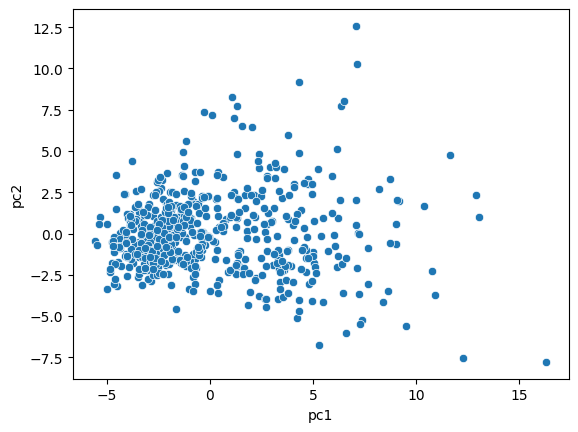

In [19]:
# 산점도로 2개의 주성분을 시각화
ax = sns.scatterplot(x='pc1', y='pc2', data=X_pca_df)

- 이제 악성과 양성이 어떻게 분포되어있는지도 한번 구분해서 보자.
- 주성분 정보가 담긴 데이터프레임에 원 타겟 데이터의 레이블을 Merge해보자. 

In [20]:
# Target과 확인을 위해 주성분 분석을 수행한 Input 데이터와 기존 Target 데이터를 Merge
# pca_df 생성: 2개의 주성분(Input) 및 1개의 Target (diagnosis)
target_df = target_df.reset_index()
pca_df = pd.merge(X_pca_df, target_df, left_index = True, right_index = True, how = 'inner')
pca_df = pca_df[['pc1', 'pc2', 'diagnosis']]
pca_df

,pc1,pc2,diagnosis
0,9.192837,1.948583,M
1,2.387802,-3.768172,M
2,5.733896,-1.075174,M
3,7.122953,10.275589,M
4,3.935302,-1.948072,M
...,...,...,...
564,6.439315,-3.576817,M
565,3.793382,-3.584048,M
566,1.256179,-1.902297,M
567,10.374794,1.672010,M


- 이제 악성과 양성별의 산점도 결과를 다시 한번 보자. 

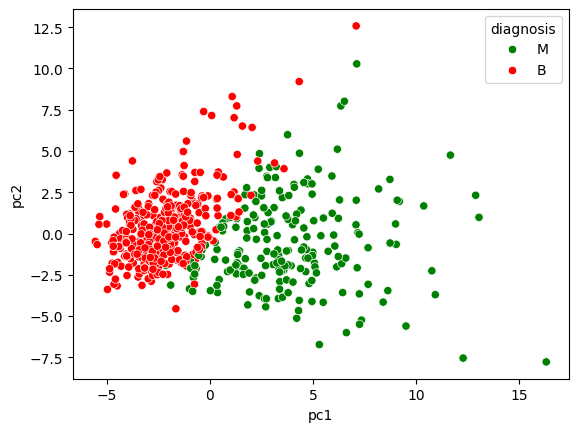

In [21]:
# 클래스를 색깔로 구분하여 처음 두 개의 주성분으로 Target과 비교
ax = sns.scatterplot(x='pc1', y='pc2', hue='diagnosis', data=pca_df, palette=['green', 'red'])

- 보면 그래프 내 왼쪽, 그리고 오른쪽으로 비교적 구분이 되어있는 형상으로 보여진다.
- 완벽한 구분이라고 하기는 어렵지만, 두 개의 주성분을 봤을때, 어느 정도 구분은 이루어져 있는 것으로 보인다.
- 각 타겟별로 집중 분포된 지역이 있기 때문이다.
- 이처럼 두 개의 주성분을 모델링에 활용한다고 하더라도 꽤 나쁘지 않은 결과를 가져올 것으로 보여진다.
- 또한 30개의 컬럼을 두개만 써도 되도록 바꾼다면 연산의 효율성은 엄청나게 확보된다고 볼 수 있다.
- 더불어 성능까지 확보된다면 그보다 더 좋은 결과는 없을 것

> 요약
- 실제 모델링에 적용하기 위해 효율적으로 활용가능한 주성분 분석
- 특히, record 및 컬럼이 많은 경우 모델링 연산비용이 많이 들게 되므로 효율적인 차원 축소 기반의 특징을 생성하는 것이 분석과정 내 필요한 과정

> 주성분을 선택하는 다른 방안
- 다음으로 주성분 선택을 할 때, 개수를 지정하는 게 아니라, 전체 원본 데이터의 분산을 특정 비율 이상으로 설명하는 수준으로 선택하는 방안도 있다. (`분산의 설명가능 수준을 비율로 선택 가능`: `1 이하의 소수점으로 입력`)
  - pca = PCA(n_components=0.8):
  - 주성분의 수는 전체 분산의 최소 80% 수준에서 설명하는 수준에서 자동으로 선택
- 이를 통해 수치를 변경하면서 추출되는 주성분의 수 확인 가능하며, 이는 분산에 기초한 주성분 개수를 선택하는 부분에서 얼마나 많은 주성분을 사용할 것인지 확인해야 할 때 사용 가능

In [22]:
# 전체 분산의 최소 80% 수준에서 설명하는 수준의 주성분 확보
pca = PCA(n_components=0.8)
pca.fit(input_scaled)
X_pca = pca.transform(input_scaled)
X_pca_df = pd.DataFrame(X_pca)
X_pca_df

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [24]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# SimpleImputer를 사용하여 결측치를 열의 평균값으로 대체
imputer = SimpleImputer(strategy='mean')
input_scaled_imputed = imputer.fit_transform(input_scaled)

# 전체 분산의 최소 80% 수준에서 설명하는 수준의 주성분 확보
pca = PCA(n_components=0.8)
pca.fit(input_scaled_imputed)
X_pca = pca.transform(input_scaled_imputed)

# 결과를 데이터프레임으로 변환
X_pca_df = pd.DataFrame(X_pca)
X_pca_df

C:\Users\user\anaconda3\envs\dx_env\Lib\site-packages\sklearn\impute\_base.py:598: UserWarning: Skipping features without any observed values: [30]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


,0,1,2,3,4
0,9.192837,1.948583,-1.123166,-3.633731,1.195110
1,2.387802,-3.768172,-0.529293,-1.118264,-0.621775
2,5.733896,-1.075174,-0.551748,-0.912083,0.177086
3,7.122953,10.275589,-3.232790,-0.152547,2.960878
4,3.935302,-1.948072,1.389767,-2.940639,-0.546747
...,...,...,...,...,...
564,6.439315,-3.576817,2.459487,-1.177314,0.074824
565,3.793382,-3.584048,2.088476,2.506028,0.510723
566,1.256179,-1.902297,0.562731,2.089227,-1.809991
567,10.374794,1.672010,-1.877029,2.356031,0.033742


### 3-1. 차원 축소 기반 특징 생성(2) : `clustering (군집 분석)`
- 여러 개의 변수를 하나의 변수(군집결과)로 변환 차원 축소
- 해당 데이터를 하나의 변수로 만들어내고, 스태킹해서, 향후 분류나 회귀 문제에서 쓰이도록 할 수 있다.
- 이번 군집분석에서는 데이터 자체가 연속형 데이터로 이루어져 있기 때문에, 대표적 군집분석 알고리즘인 k-means를 활용해보도록 하겠다.

In [26]:
# 먼저 사이킷런 내 k-means import
from sklearn.cluster import KMeans

In [31]:
# 일부 변수만 선택 (30개 변수 중 15개의 변수만 임의로 선정) 
# 즉, 활용할 정보의 양을 절반으로 축소
# --> Q. 과연 15개 변수만 가지고 군집분석 진행 해당 군집 결과 얼마나 효율적일지?
subset_df = input_df.iloc[:,0:15]
subset_df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se
id,,,,,,,,,,,,,,,
842302,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399
842517,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225
84300903,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150
84348301,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110
84358402,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926424,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300
926682,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769
926954,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903


- k-means도 역시 데이터 간 거리를 기반으로 해서 가까운 데이터끼리 묶어 군집으로 도출해주는 알고리즘이기 때문에,
- 데이터별로 관측범위가 서로 다르다. (칼럼마다) --> 따라서 정규화 진행!

In [32]:
# 데이터 스케일링
std_scaler.fit(subset_df)
subset_input_scaled = std_scaler.transform(subset_df)
subset_input_scaled # 앞선 예시처럼 array 형태가 나온다. 

array([[ 1.09706398, -2.07333501,  1.26993369, ...,  2.83303087,
         2.48757756, -0.21400165],
       [ 1.82982061, -0.35363241,  1.68595471, ...,  0.26332697,
         0.74240195, -0.60535085],
       [ 1.57988811,  0.45618695,  1.56650313, ...,  0.8509283 ,
         1.18133606, -0.29700501],
       ...,
       [ 0.70228425,  2.0455738 ,  0.67267578, ...,  0.27669279,
         0.1806983 , -0.37934168],
       [ 1.83834103,  2.33645719,  1.98252415, ...,  1.43852964,
         1.0095027 , -0.17299998],
       [-1.80840125,  1.22179204, -1.81438851, ..., -0.15744905,
        -0.46615196,  0.04934236]])

In [34]:
# K-means 클러스터링 활용
# 먼저, 군집 Label 수를 사전에 설정해주어야 한다. 
k=5
model = KMeans(n_clusters = k, random_state = 10) # 모델을 다음과 같이 선언

In [35]:
# scaling 한 데이터를 fit 하여 모델 학습
model.fit(subset_input_scaled)

# 클러스터링 결과를 타겟 변수와 비교하기 위하여 원 데이터에 컬럼으로 생성
target_df['cluster'] = model.fit_predict(subset_input_scaled)

C:\Users\user\anaconda3\envs\dx_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\Users\user\anaconda3\envs\dx_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


In [36]:
# 최종 데이터 확인
target_df

,id,diagnosis,cluster
0,842302,M,2
1,842517,M,3
2,84300903,M,3
3,84348301,M,4
4,84358402,M,3
...,...,...,...
564,926424,M,2
565,926682,M,3
566,926954,M,1
567,927241,M,2


- 해당 군집 결과가 과연, 이 진단 컬럼인 악성과 양성과 얼마나 범주로 교차해서 볼 수 있는지 한번 비교해서 보도록 하겠다.
- 비교하는 부분은 crosstab 함수로 비교해볼 수 있다. 

In [37]:
# 15개의 임의 변수로 만들어진 하나의 특징(군집결과)과 기존 Target 변수 비교
pd.crosstab(target_df.diagnosis, target_df.cluster)

cluster,0,1,2,3,4
diagnosis,,,,,
B,225,53,0,2,77
M,5,55,30,101,21


- 결과를 보니, B는 양성, M은 악성을 뜻하는데, 클러스터가 0번, 2번인 경우는 완벽하게 몰려져 있다.
- 4번도 대다수는 B로 몰려져 있다. 

- 30개의 변수가 아니라, 15개인 변수만을 활용해서 생성한 하나의 특징, 이 군집 결과가 타겟변수와 비교한 결과,
- 비교적 잘 나눠진 결과를 보이고 있다. (1번 제외)
- 만일 15개보다 더 많은 정보를 사용하거나, 아니면 이 군집모델을 좀 더 정교하게 만든다면,
- 좀 더 좋은 결과를 얻을 수도 있을 것 같다. 

- 이처럼 많은 변수들을 하나의 특징으로 구성을 하고, 입력 데이터의 차원을 줄인다면,
- 모델 연산비용 절감에 굉장히 효과적이고, 성능까지 확보한다면 가장 좋은 결과를 획득한다고 말할 수 있다. 